# Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -r sample_data

In [3]:
!pip install timm

     |████████████████████████████████| 431 kB 5.2 MB/s 


In [4]:
# !pip install albumentations==0.4.6

# Libraries

In [5]:
import torch
import timm
import pandas as pd
import os
import cv2
import numpy as np

print("torch_version: " + torch.__version__)
print("timm_version: " + timm.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

torch_version: 1.10.0+cu111
timm_version: 0.5.4


('1.10.0+cu111', 'cuda')

# csv

In [6]:
PATH = "/content/drive/MyDrive/ISIC/2016"
os.listdir(PATH)

['ISBI2016_ISIC_Part3_Training_Data.zip',
 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Test_Data.zip',
 'ISBI2016_ISIC_Part3_Test_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Training_Data',
 'ISBI2016_ISIC_Part3_Test_Data']

In [76]:
train_path = f'{PATH}/ISBI2016_ISIC_Part3_Training_Data/'
test_path = f'{PATH}/ISBI2016_ISIC_Part3_Test_Data/'

train_csv = f'{PATH}/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
test_csv = f'{PATH}/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'

header_list = ['image_name','benign_malignant']
train = pd.read_csv(train_csv, names=header_list, index_col=False)

header_list = ['image_name','target']
test = pd.read_csv(test_csv, names=header_list, index_col=False)

In [77]:
def to_int(label):
  if label == "benign":
    return 0.0
  elif label == "malignant":
    return 1.0

def to_path_train(image_name):
  return train_path +image_name+'.jpg'

def to_path_test(image_name):
  return test_path +image_name+'.jpg'
train['target'] = train.benign_malignant.apply(to_int)
train['path'] = train.image_name.apply(to_path_train)

test['path'] = test.image_name.apply(to_path_test)

In [78]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train, random_state=42, test_size=0.33, shuffle=True, stratify=train['target'])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
train_split.shape, val_split.shape

In [9]:
# import numpy as np
# from sklearn import model_selection
# FOLDS = 3
# kf = model_selection.StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)
# for fold_, (train_idx, test_idx) in enumerate(kf.split(X=train,y=train['target'])):
#   train.loc[test_idx,'kfold'] = fold_

#   train_fold = train.iloc[train_idx]
#   val_fold = train.iloc[test_idx]
#   train_fold.reset_index(drop=True, inplace=True)
#   val_fold.reset_index(drop=True, inplace=True)
#   train_fold.to_csv(f'./train_fold{FOLDS}.csv')
#   val_fold.to_csv(f'./val_fold{FOLDS}.csv')
#   print("Fold:",fold_+1)
#   print(train_idx.shape, test_idx.shape)

Fold: 1
(600,) (300,)
Fold: 2
(600,) (300,)
Fold: 3
(600,) (300,)


# Dataset class

In [10]:
params = {
    "model": "resnet101",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 128,
    "num_workers": 4,
    "epochs": 10,
    "lr_scheduler": False,
    "early_stopping": False
}

In [11]:
from torch.utils.data import Dataset
from skimage import io
from skimage.transform import resize

import cv2
class MelanomaDataset(Dataset):
  def __init__(self, images, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = torch.tensor([self.labels[index]])
    if self.transform is not None:
      image = self.transform(image=image)["image"].astype(np.float32)
      image = image.transpose(2, 0, 1)
    else:
      image = image.astype(np.float32)/ 255.0
      image = image.transpose(2, 0, 1)
    if self.train:
      return torch.tensor(image).float(), target.float()
    return torch.tensor(image).float()

  def __len__(self) -> int:
    return len(self.images)

# Data Loader

In [89]:
from torch.utils.data import DataLoader
dataset = {
    'train': MelanomaDataset(train_split['path'], train_split['target']),
    'val': MelanomaDataset(train_split['path'], train_split['target'])
}

In [90]:
train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'])

In [91]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 1]))

# Show batch

In [92]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

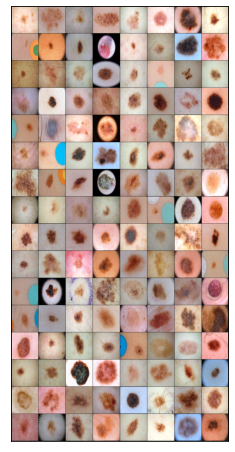

In [93]:
show_batch(train_loader)

# Generate mean and std from dataset
mean: (0.72196096, 0.6170128, 0.56728417) \\
std: (0.16372901, 0.17203921, 0.19337493)

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
      # Mean over batch, height and width, but not over the channels
      channels_sum += torch.mean(data, dim=[0,2,3])
      channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
      num_batches += 1
    mean = channels_sum / num_batches
    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return tuple(mean.numpy()), tuple(std.numpy())

In [ ]:
mean, std = get_mean_and_std(DataLoader(dataset['train']))
print(mean)
print(std)

## compute_img_mean_std function (not used)

In [ ]:
#use this training model from scratch or not using pretrained model
from tqdm import tqdm
def compute_img_mean_std(image_paths):
    '''
    normalising data from 0-255 to 0-1
    mean and std of three channnel
    '''
    img_h, img_w = 224,224
    imgs = []
    means, stds = [],[]
    #resizing 
    for i in tqdm(image_paths):
        img = cv2.imread(i)
        img.resize(img_w,img_h)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    # (224,224,3),nof_img -> 224,224,3,nof_img
    imgs = np.stack(imgs, axis=3)
    #normalising 
    imgs=imgs.astype(np.float32)/255.
    
    print(imgs.shape)
    #mean and std of each channel
    for i in range(3):
        pixels = imgs[:,:,i,:].ravel() #resizing to one row
        mean = pixels.mean()
        std = pixels.std()
        
        means.append(mean)
        stds.append(std)
        
    means.reverse() #bgr to rgb
    stds.reverse()
    
    print(f'mean {means}')
    print(f'std {stds}')
    return means, stds

In [ ]:
compute_img_mean_std(train['path'])

# Augmentation

In [80]:
mean= (0.72196096, 0.6170128, 0.56728417)
std= (0.16372901, 0.17203921, 0.19337493)

In [81]:
import albumentations as A

def transform_aug(im_size):
  transforms_train = A.Compose(
      [
       A.Transpose(p=0.5),
       A.VerticalFlip(p=0.5),
       A.HorizontalFlip(p=0.5),
       A.RandomBrightness(limit=0.2, p=0.75),
       A.RandomContrast(limit=0.2, p=0.75),
       A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.Blur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),
       A.OneOf([
                A.OpticalDistortion(distort_limit=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.),
                A.ElasticTransform(alpha=3),
                ], p=0.7),
       A.CLAHE(clip_limit=4.0, p=0.7),
       A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
       A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
       A.Resize(im_size, im_size),
       A.Cutout(max_h_size=int(im_size * 0.375), max_w_size=int(im_size * 0.375), num_holes=1, p=0.7),
       A.Normalize(mean,std)
       ])
  
  transforms_val = A.Compose(
      [
       A.SmallestMaxSize(max_size=160),
       A.CenterCrop(height=128, width=128),
       A.Normalize(mean, std)
       ])
  return transforms_train, transforms_val

In [83]:
from torch.utils.data import DataLoader
transforms_train, transforms_val = transform_aug(224)

dataset = {
    'train': MelanomaDataset(train_split['path'], train_split['target'],transform=transforms_train),
    'val': MelanomaDataset(val_split['path'], val_split['target'],transform=transforms_val)
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'])

images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 1]))

## Visualize augmentation

In [84]:
import random
import copy
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image/255.)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [107]:
import matplotlib.pyplot as plt
random.seed(42)
visualize_augmentations(dataset['train'])

# Model

In [94]:
import timm
import torch.nn as nn
class MelanomaClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, n_class)
    def forward(self, x):
        x = self.model(x)
        return x

In [95]:
model = MelanomaClassifier(params['model'],n_class=1,pretrained=True)

## parameters

In [96]:
from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

optimizer = AdamP(model.parameters(), lr=params['lr'])
# criterion = BinaryCrossEntropy()
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

## Learning rate scheduler | Early stopping

In [97]:
from timm.scheduler.plateau_lr import PlateauLRScheduler

class LRSchedulerPlateau():
  def __init__(self, optimizer, patience_t=3, threshold=1e-6, mode="min", warmup_t=10, warmup_lr_init=0.0002):
    self.optimizer = optimizer
    self.patience_t = patience_t
    self.threshold = threshold
    self.mode = mode
    self.warmup_t = warmup_t
    self.warmup_lr_init = warmup_lr_init
    self.lr_scheduler = scheduler = PlateauLRScheduler(self.optimizer,patience_t=self.patience_t,threshold=self.threshold, mode=self.mode, warmup_t=self.warmup_t, warmup_lr_init=self.warmup_lr_init)
  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

#### Visualization of the learning rate reduction per epoch

In [ ]:
def get_lr_per_epoch(scheduler, num_epoch):
    lr_per_epoch = []
    for epoch in range(num_epoch):
        lr_per_epoch.append(scheduler.get_epoch_values(epoch))
    return lr_per_epoch

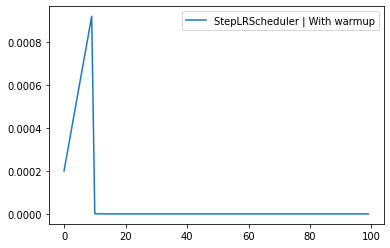

In [ ]:
from timm.scheduler.step_lr import StepLRScheduler
num_epoch = 100
scheduler = StepLRScheduler(optimizer, decay_t = num_epoch/100, decay_rate=.5, warmup_t=num_epoch/10, warmup_lr_init=num_epoch/500000)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)

plt.plot([i for i in range(num_epoch)], lr_per_epoch, label="StepLRScheduler | With warmup");
plt.legend();

In [ ]:
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)

### Early stopping

In [98]:
class EarlyStopping():
  def __init__(self, patience=5, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
    if self.counter >= self.patience:
      print('INFO: Early stopping')
      self.early_stop = True

# args

In [106]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
args = vars(parser.parse_args())

# Metrics

In [100]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

def auc_score(outputs, targets):
  outputs = torch.sigmoid(outputs)
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  auc = roc_auc_score(targets, outputs)
  return auc

def f1_score(outputs, targets):
  outputs = torch.sigmoid(outputs)
  outputs = outputs.detach().numpy()
  targets = targets.detach().numpy()
  f1 = f1_score(targets, outputs)
  return f1

def accuracy_score(output, target):
  output = torch.sigmoid(output) >= 0.5
  target = target == 1.0
  return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

# Train

In [101]:
from collections import defaultdict
class MetricMonitor:
  def __init__(self, float_precision=3):
    self.float_precision = float_precision
    self.reset()
    
  def reset(self):
    self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

  def update(self, metric_name, val):
    metric = self.metrics[metric_name]

    metric["val"] += val
    metric["count"] += 1
    metric["avg"] = metric["val"] / metric["count"]
  def __str__(self):
    return " | ".join(
        ["{metric_name}: {avg:.{float_precision}f}".format(metric_name=metric_name,
                                                           avg=metric["avg"],
                                                           float_precision=self.float_precision)
        for (metric_name, metric) in self.metrics.items()])

In [102]:
from statistics import mean
def train(train_loader, model, criterion, optimizer, epoch, params):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)
  train_running_loss = []
  train_running_acc = []
  train_running_auc = []
  for _, batch in enumerate(stream, start=1):
    images, targets = batch
    images = images.to(params["device"], non_blocking=True)
    targets = targets.to(params["device"], non_blocking=True).float().view(-1, 1)
    outputs = model(images)
    loss = criterion(outputs, targets)
    accuracy = accuracy_score(outputs, targets)
    auc = auc_score(outputs, targets)
    # scheduler.step(auc)
    train_running_loss.append(loss.item())
    train_running_acc.append(accuracy)
    train_running_auc.append(auc)

    metric_monitor.update("Loss", loss.item())
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("AUC", auc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
  return mean(train_running_loss), mean(train_running_acc), mean(train_running_auc)
  

In [103]:
def validate(val_loader, model, criterion, epoch, params):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  best_auc=0
  val_running_loss = []
  val_running_auc = []
  val_running_acc = []
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      images, target = batch
      images = images.to(params["device"], non_blocking=True)
      targets = target.to(params["device"], non_blocking=True).float().view(-1, 1)
      outputs = model(images)
      loss = criterion(outputs, targets)
      accuracy = accuracy_score(outputs, targets)
      auc = auc_score(outputs, targets)
      val_running_loss.append(loss.item())
      val_running_acc.append(accuracy)
      val_running_auc.append(auc)
      metric_monitor.update("Loss", loss.item())
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("AUC", auc)
      stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
  # if auc > best_auc:
  #   best_auc = auc
  #   # torch.save(model, f'{PATH}/model.pth')
  #   torch.save(model, 'model.pth')
  #   print(f"Current best model: {auc:.5f}")
  return mean(val_running_loss), mean(val_running_acc), mean(val_running_auc)



# Training loop

In [104]:
from tqdm import tqdm
import time

train_loss, train_acc, train_auc, val_loss, val_acc, val_auc = [], [], [], [], [], []
start = time.time()

lr_scheduler = LRSchedulerPlateau(optimizer)
early_stopping = EarlyStopping()

model.cuda()

for epoch in range(1, params["epochs"] + 1):
  train_epoch_loss, train_epoch_acc, train_epoch_auc = train(train_loader, model, criterion, optimizer, epoch, params)
  val_epoch_loss, val_epoch_acc, val_epoch_auc = validate(val_loader, model, criterion, epoch, params)
  train_loss.append(train_epoch_loss);train_acc.append(train_epoch_acc);train_auc.append(train_epoch_auc)
  val_loss.append(val_epoch_loss);val_acc.append(val_epoch_acc);val_auc.append(val_epoch_auc)
  if params['lr_scheduler']:
    lr_scheduler(val_epoch_loss)
  if params['early_stopping']:
    early_stopping(val_epoch_loss)
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch: 1. Train. Loss: 0.723 | Accuracy: 0.679 | AUC: 0.561: 100%|██████████| 5/5 [00:32<00:00,  6.45s/it]
Epoch: 1. Validation. Loss: 1.076 | Accuracy: 0.455 | AUC: 0.664: 100%|██████████| 5/5 [00:29<00:00,  5.95s/it]
Epoch: 2. Train. Loss: 0.448 | Accuracy: 0.829 | AUC: 0.788: 100%|██████████| 5/5 [00:31<00:00,  6.33s/it]
Epoch: 2. Validation. Loss: 0.491 | Accuracy: 0.771 | AUC: 0.707: 100%|██████████| 5/5 [00:30<00:00,  6.03s/it]
Epoch: 3. Train. Loss: 0.291 | Accuracy: 0.869 | AUC: 0.918: 100%|██████████| 5/5 [00:31<00:00,  6.33s/it]
Epoch: 3. Validation. Loss: 0.710 | Accuracy: 0.828 | AUC: 0.822: 100%|██████████| 5/5 [00:29<00:00,  5.93s/it]
Epoch: 4. Train. Loss: 0.159 | Accuracy: 0.939 | AUC: 0.978: 100%|██████████| 5/5 [00:31<00:00,  6.24s/it]
Epoch: 4. Validation. Loss: 0.811 | Accuracy: 0.829 | AUC: 0.772: 100%|██████████| 5/5 [00:29<00:00,  5.96s/it]
Epoch: 5. Train. Loss: 0.109 | Accuracy: 0.962 | AUC: 0.993: 100%|██████████| 5/5 [00:31<00:00,  6.22s/it]
Epoch: 5. Validat

Training time: 10.203 minutes


# Visuals

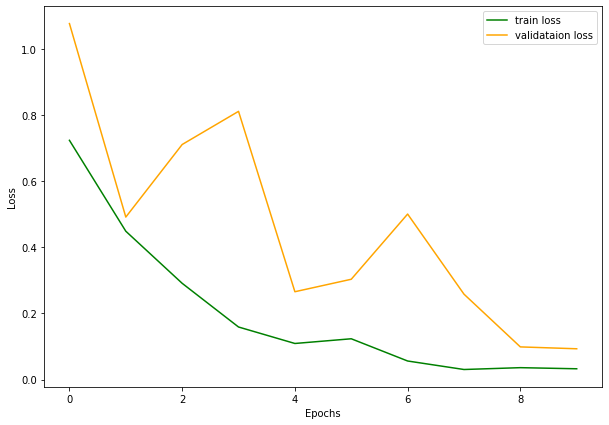

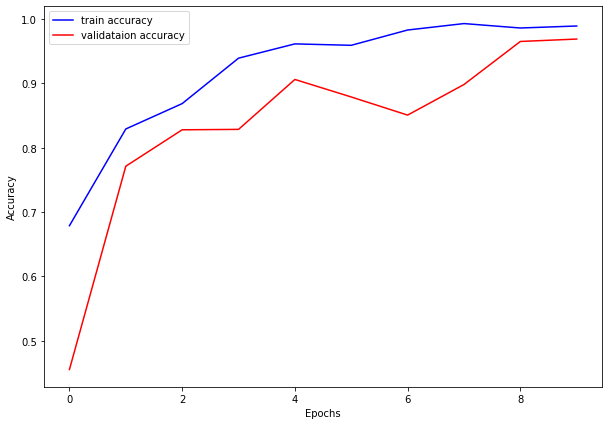

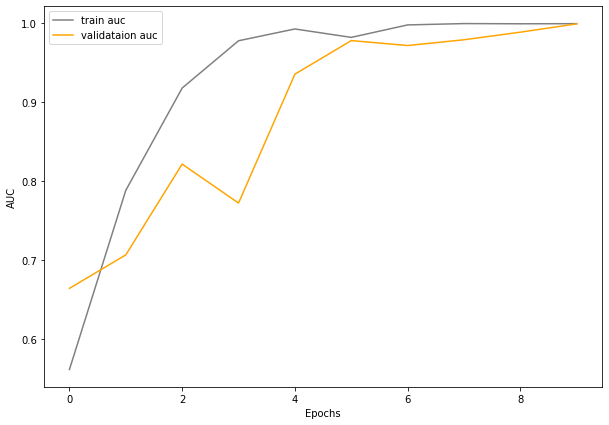

Saving model...
TRAINING COMPLETE


In [105]:
import matplotlib.pyplot as plt

loss_plot_name = 'loss'
acc_plot_name = 'accuracy'
auc_plot_name = 'auc'


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='green', label='train loss')
plt.plot(val_loss, color='orange', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./{loss_plot_name}.png")
plt.show()
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"./{acc_plot_name}.png")
plt.show()
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_auc, color='grey', label='train auc')
plt.plot(val_auc, color='orange', label='validataion auc')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.savefig(f"./{auc_plot_name}.png")
plt.show()


# serialize the model to disk
print('Saving model...')
torch.save(model.state_dict(), f"./{model_name}.pth")
 
print('TRAINING COMPLETE')